In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from file_utils import load_dataframes
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

sns.set_theme()

dataset_dir = "data"

# Load data
Usuwamy wiersze które nie mają przypisanego id

In [2]:
items = pd.read_csv(
    f"{dataset_dir}/items.csv",
    na_values="unknown",
    dtype={"item_id": "Int64", "alley_id": "Int64", "category": "Int64"},
)
items.drop(columns="Unnamed: 0", inplace=True)
items.dropna(subset=["item_id"], inplace=True)

In [3]:
categories = pd.read_csv("data/categories.csv", index_col="category_id")
categories.drop(columns="Unnamed: 0", inplace=True)

In [4]:
alley_inventory = pd.read_csv("data/alley_inventory.csv", index_col="alley_id")

In [5]:
transaction_items__prior = pd.read_csv(
    "data/transaction_items__prior.csv",
    na_values="unknown",
    dtype={"transaction_id": "Int64", "item_id": "Int64", "add_to_cart_order": "Int16", "previous_bought": "Int8"},
)
transaction_items__prior.drop(columns=["Unnamed: 0"], inplace=True)
transaction_items__prior.dropna(subset=["transaction_id", "item_id"], inplace=True)

In [6]:
transactions = pd.read_csv(
    "data/transactions.csv",
    na_values="unknown",
    dtype={
        "transaction_id": "Int64",
        "customer_id": "Int64",
        "transaction_number": "Int64",
        "day_of_week": "category",
        "time_of_day": "Int8",
        "days_since_prior_order": "Int64",
    },
)

transactions.drop(columns="Unnamed: 0", inplace=True)
transactions.dropna(subset=["transaction_id"], inplace=True)
transactions.set_index(["transaction_id"], inplace=True)

# Data exploration
## Dataframes
Jest 3204781 transakcji i 47616 itemów które mają poprawnie ustawione id
Mamy 21 kategorii i 134 alejki

## Items
Dołączamy kategorie i alejki do itemów

In [13]:
print(f"Total transactions: {transactions.shape[0]}")
print(f"Total items: {items.shape[0]}")
print(f"Total categories: {categories.shape[0]}")
print(f"Total alleys: {alley_inventory.shape[0]}")

Total transactions: 3204781
Total items: 47616
Total categories: 21
Total alleys: 134


In [14]:
items_data = pd.merge(items, categories, left_on="category", right_on="category_id", how="left")
items_data = pd.merge(items_data, alley_inventory, left_on="alley_id", right_on="alley_id", how="left")
items_data.drop(columns=["category_x", "alley_id"], inplace=True)
items_data.rename(columns={"category_y": "category"}, inplace=True)

# Category analysis
Najwięcej produktów należy do kategorii: personal_care, snacks, pantry, beverages i frozen

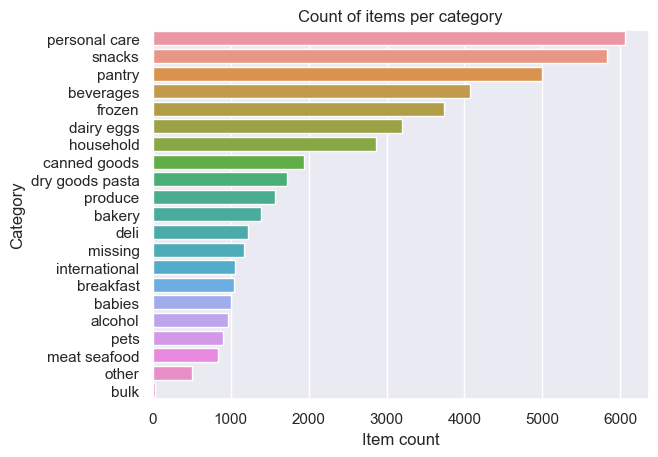

In [18]:
ax = sns.countplot(y="category", data=items_data, order=items_data["category"].value_counts().index)
plt.title("Count of items per category")
ax.set(xlabel="Item count", ylabel="Category")
plt.show()

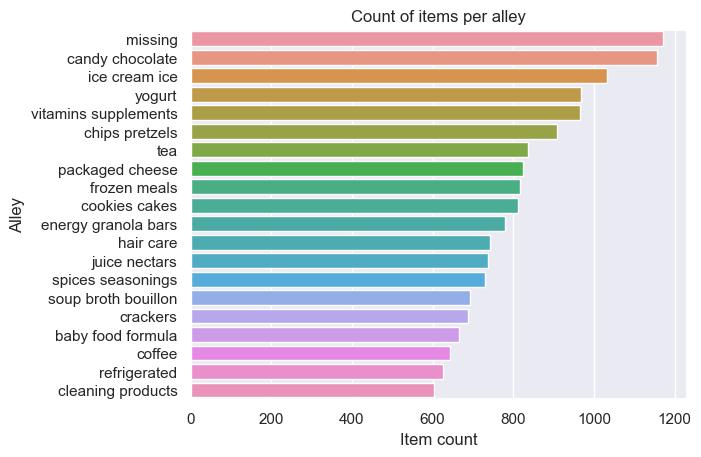

In [25]:
ax = sns.countplot(y="alley", data=items_data, order=items_data["alley"].value_counts().iloc[:20].index)
plt.title("Count of items per alley")
ax.set(xlabel="Item count", ylabel="Alley")
plt.show()

# Transaction analysis
Dołączamy do informacji o transakcjach itemy i ich dane, a także informacje o zamówieniu do którego należą, dodałem też kolumnę quantity równą 1 żeby łatwiej było policzyć ile razy dany produkt został kupiony
Jest 28844909 transakcji do których da się przypisać itemy, 4% transakcji nie ma poprawnie przypisanego item id

In [27]:
transaction_items = pd.merge(transaction_items__prior, items_data, on="item_id")
transaction_items["quantity"] = 1

In [35]:
print(f"Ratio of transactions without items: {1-transaction_items.shape[0]/transaction_items__prior.shape[0]}")

Ratio of transactions without items: 0.040872908492835314


In [36]:
transactions__prior = transactions[transactions["eval_set"] == "prior"]
transaction_items = pd.merge(transaction_items, transactions__prior, on="transaction_id")

In [37]:
total_bought = transaction_items.groupby("item_id")["quantity"].count().sort_values(ascending=False)
items_data = pd.merge(items_data, total_bought, on="item_id")

In [38]:
total_reordered = transaction_items.groupby("item_id")["previous_bought"].sum().sort_values(ascending=False)
total_reordered.rename("total_reordered", inplace=True)
items_data = pd.merge(items_data, total_reordered, on="item_id")

In [39]:
items_data.head()

,item_id,item_name,category,alley,quantity,total_reordered
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes,1579,944
1,2,All-Seasons Salt,pantry,spices seasonings,76,9
2,3,Robust Golden Unsweetened Oolong Tea,beverages,tea,229,158
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen,frozen meals,279,116
4,5,Green Chile Anytime Sauce,pantry,marinades meat preparation,13,8


In [40]:
items_data["reorder_ratio"] = items_data["total_reordered"] / items_data["quantity"]

In [41]:
items_data.shape[0]

47576

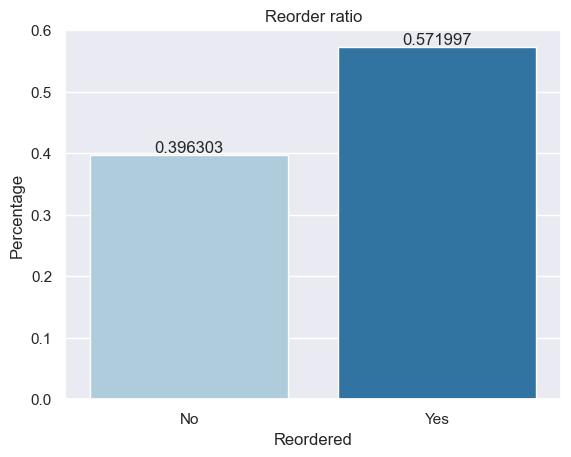

In [59]:
total_orders = transaction_items.shape[0]
reorder_ratio = transaction_items["previous_bought"].value_counts() / total_orders
ax = sns.barplot(x=reorder_ratio.index, y=reorder_ratio.values, palette="Paired")
ax.set(xlabel="Reordered", ylabel="Percentage")
ax.set_xticklabels(["No", "Yes"])
ax.bar_label(ax.containers[0])
plt.title("Reorder ratio")
plt.show()

In [43]:
print(f"Total orders: {total_orders}")
print(f'Total reordered products: {transaction_items["previous_bought"].sum()}')
print(f'Reorder ratio: {transaction_items["previous_bought"].sum()/total_orders}')

Total orders: 26745804
Total reordered products: 15298528
Reorder ratio: 0.5719973121765194


In [44]:
never_reordered_items = items_data[(items_data["quantity"] > 10) & (items_data["total_reordered"] == 0)]

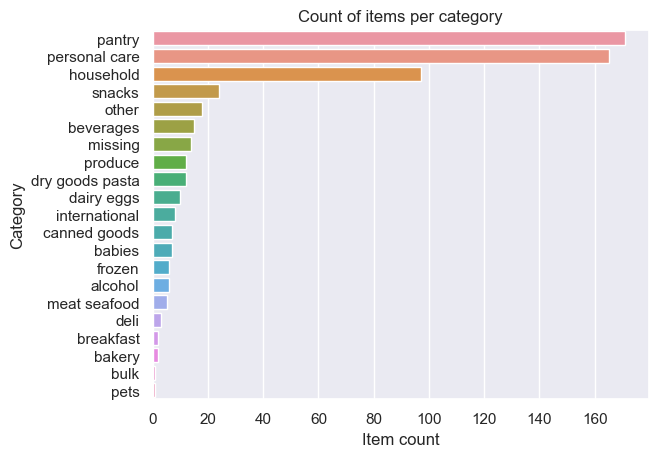

In [45]:
ax = sns.countplot(
    y="category", data=never_reordered_items, order=never_reordered_items["category"].value_counts().index
)
plt.title("Count of items per category")
ax.set(xlabel="Item count", ylabel="Category")
plt.show()

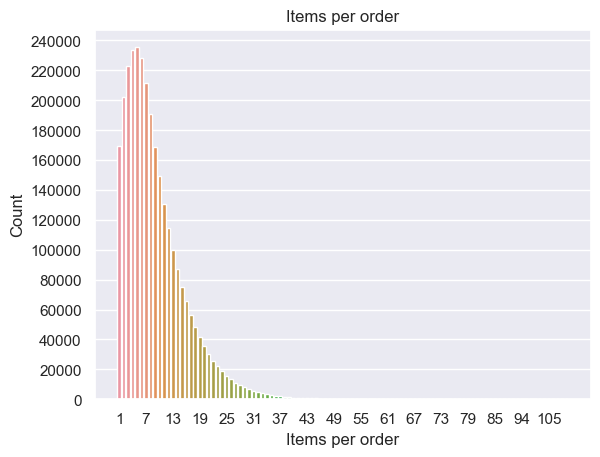

In [46]:
items_per_order = transaction_items.groupby("transaction_id", as_index=False)["item_id"].count()
items_per_order.rename(columns={"item_id": "items_per_order"}, inplace=True)
ax = sns.countplot(x="items_per_order", data=items_per_order)
plt.title("Items per order")
ax.set(xlabel="Items per order", ylabel="Count")
plt.locator_params(nbins=20)
plt.show()

In [47]:
position_reorders = transaction_items.groupby("add_to_cart_order").agg({"previous_bought": ["sum", "count", "mean"]})
position_reorders.columns = ["reordered", "total_orders", "reorder_ratio"]

In [48]:
position_reorders

,reordered,total_orders,reorder_ratio
add_to_cart_order,,,
1,1693876,2494551,0.67903
2,1607558,2372398,0.677609
3,1466120,2224204,0.659166
4,1315340,2061754,0.637971
5,1168635,1889305,0.618553
...,...,...,...
141,0,1,0.0
142,0,1,0.0
143,0,1,0.0


In [49]:
position_reorders.describe()

,reordered,total_orders,reorder_ratio
count,143.0,1.430000e+02,143.0
mean,103595.202797,1.753695e+05,0.413952
std,307720.753942,4.867347e+05,0.162189
min,0.0,1.000000e+00,0.0
25%,4.0,9.000000e+00,0.398223
50%,74.0,1.750000e+02,0.42446
75%,8964.0,2.131000e+04,0.498462
max,1693876.0,2.494551e+06,1.0


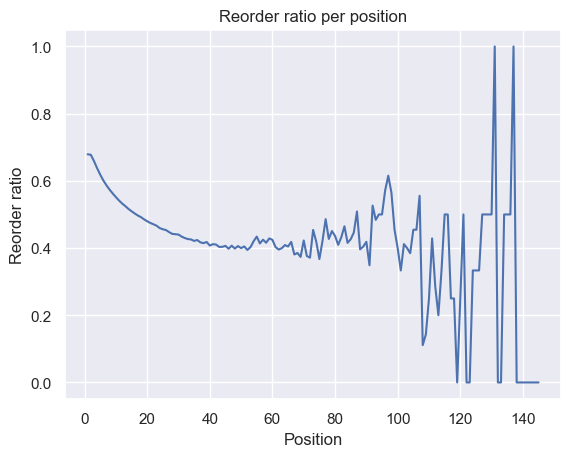

In [50]:
ax = sns.lineplot(x=position_reorders.index.astype(int), y=position_reorders["reorder_ratio"])
plt.title("Reorder ratio per position")
ax.set(xlabel="Position", ylabel="Reorder ratio")
plt.show()

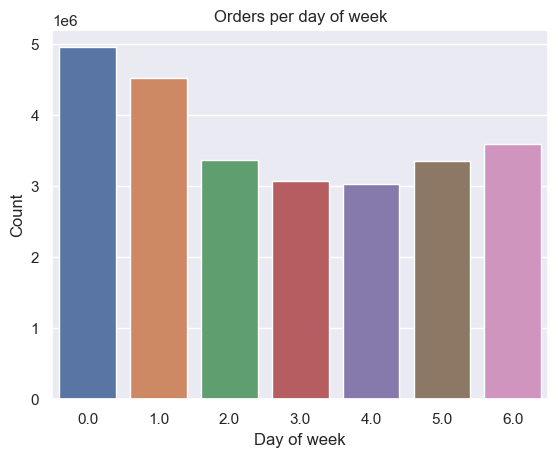

In [51]:
ax = sns.countplot(x="day_of_week", data=transaction_items.loc[~transaction_items["day_of_week"].isna()])
plt.title("Orders per day of week")
ax.set(xlabel="Day of week", ylabel="Count")
plt.show()

In [52]:
import datetime

hour_nums = list(range(24))
hours_of_day = {hour_num: datetime.time(hour=hour_num).strftime("%I:00 %p") for hour_num in hour_nums}
transaction_items["time_of_day"] = transaction_items["time_of_day"].map(hours_of_day)
transaction_items["time_of_day"] = pd.Categorical(transaction_items["time_of_day"], categories=hours_of_day.values())

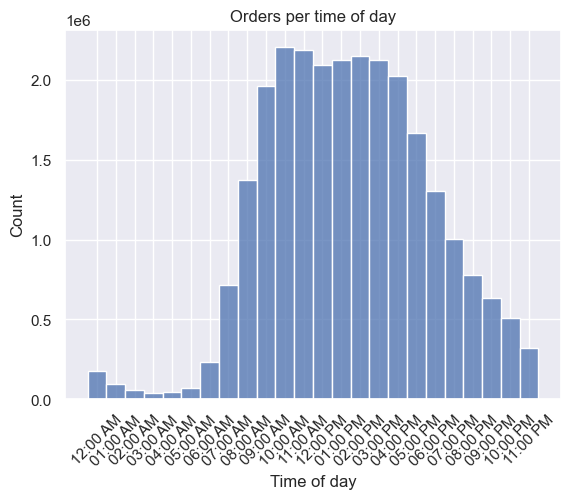

In [53]:
ax = sns.histplot(x="time_of_day", data=transaction_items, bins=24)
plt.title("Orders per time of day")
ax.set(xlabel="Time of day", ylabel="Count")
plt.xticks(rotation=45)
plt.show()